### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar100 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 2

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [3]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [4]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[i]) / (i + 1) for i in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
    return np.mean(cumulative_averages, axis=0)

In [5]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [6]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(cumulative_averages, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [71]:
def plot_cumulative_subplots(accuracy_arrays, subtitles, plot_filename=""):
    assert len(accuracy_arrays) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    labels = ["Without Drift", "With Drift", "Drift with Full Relearning", "Drift with Buffer Resampling"]

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    fig, axes = plt.subplots(1, len(accuracy_arrays) // 4, figsize=(12, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=14)
            axes[i].legend(prop={"size": 8}, loc="upper right")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 5)))

    fig.supxlabel("Task Trained On", fontsize=14)
    fig.supylabel("Accuracy (%)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

In [8]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

CIFAR100 10 Tasks, 10 Classes Per Task

# ER

## Buffer 500

### Without Drift

In [68]:
er_500_accuracy_array_without_drift = read_results(
    "./logs/01-20-25-05-14-13-seq-cifar100-er-buf-500-drift-6-n-2-adaptation-0.json"
)
# 9.43, 9.72, 9.75, 9.82, 9.97
# 9.738 ± 0.17656726763474623
# plot_results(
#     er_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_500_accuracy_array_without_drift)[1]

74.80000000000001

### With Permutation Drift in Tasks 4, 7

In [12]:
er_500_accuracy_array_with_drift = read_results(
    "./logs/01-20-25-07-10-14-seq-cifar100-er-buf-500-drift-5-n-2-adaptation-0.json"
)
# 9.36, 9.33, 9.49, 9.52, 9.55
# 9.45 ± 0.08831760866327869
# plot_results(
#     er_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 4, 7",
# )
average_forgetting(er_500_accuracy_array_with_drift)[1]

74.94444444444444

### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [13]:
# before reimplementation
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-20-25-21-28-50-seq-cifar100-er-buf-500-drift-5-n-2-adaptation-1.json"
# )
# # 13.86, 14.48, 14.51
# # 14.283333333333333 ± 0.2995923155816179

3 files found
1: ./reimplementation-logs/02-23-25-18-33-01-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-19-54-22-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-19-12-15-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 12.146666666666667
Avg Forgetting: 69.16666666666666


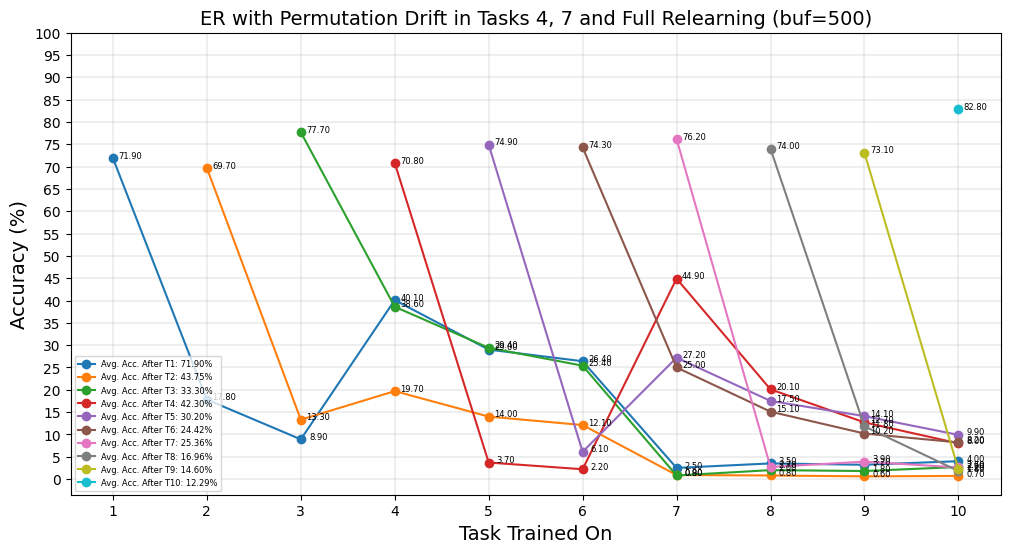

In [14]:
er_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {er_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-23-25-19-12-15-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
# 11.86, 12.29, 12.29
plot_results(
    er_500_accuracy_array_with_drift_full_relearning,
    title="ER with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_500_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [15]:
# before reimplementation
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-01-07-57-seq-cifar100-er-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 12.49, 12.52, 12.71
# # 12.573333333333332 ± 0.09741092797468347

3 files found
1: ./reimplementation-logs/02-23-25-20-25-07-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-23-25-21-25-20-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-23-25-20-55-19-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 12.566666666666668
Avg Forgetting: 70.2


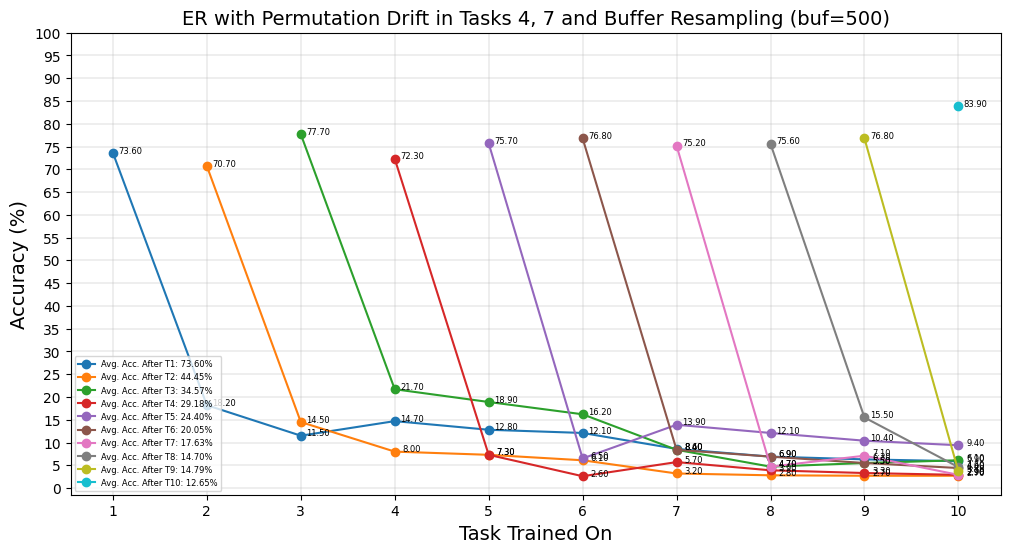

In [16]:
er_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {er_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-23-25-20-55-19-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
# 12.12, 12.65, 12.93
plot_results(
    er_500_accuracy_array_with_drift_buffer_resampling,
    title="ER with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

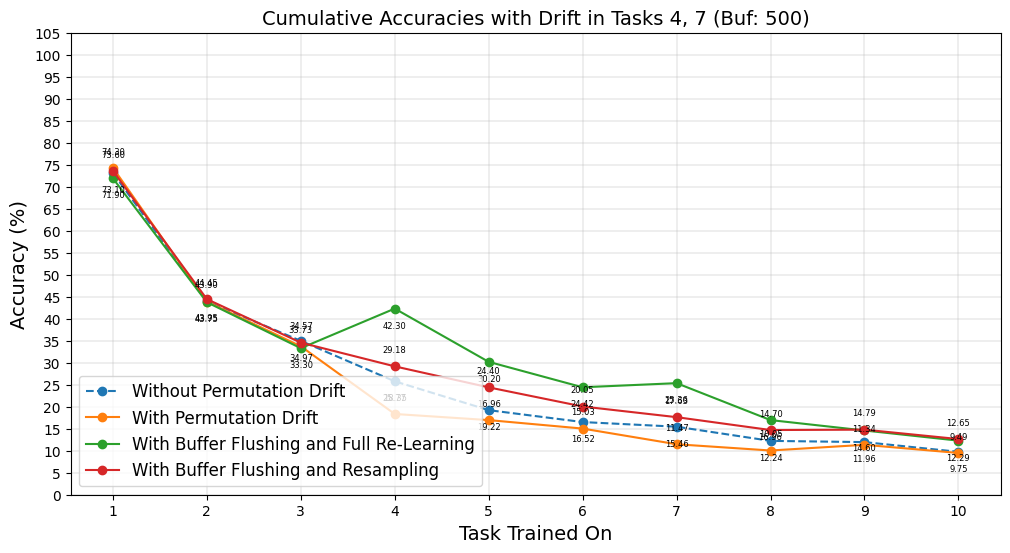

In [17]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [18]:
er_5000_accuracy_array_without_drift = read_results(
    "./logs/01-13-25-15-13-00-seq-cifar100-er-buf-5000-drift-6-n-2-severity-5-adaptation-0-cpd-0.json"
)
# 22.63, 22.76, 22.9, 22.97, 23.21
# 22.894 ± 0.1966316352980875
# plot_results(
#     er_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_5000_accuracy_array_without_drift)[1]

57.27777777777778

### With Permutation Drift in Tasks 4, 7

In [19]:
er_5000_accuracy_array_with_drift = read_results(
    "./logs/01-13-25-17-12-45-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-0-cpd-0.json"
)
# 15.35, 15.47, 15.56, 15.94, 16.54
# 15.772 ± 0.43180551177584525
# plot_results(
#     er_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 4, 7",
# )
average_forgetting(er_5000_accuracy_array_with_drift)[1]

64.33333333333333

### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [20]:
# before reimplementation
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-14-25-00-28-42-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-1-cpd-0.json"
# )
# # 25.99, 26.03, 26.09, 26.13, 26.51
# # 26.15 ± 0.18633303518163463

3 files found
1: ./reimplementation-logs/02-23-25-18-43-35-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-19-31-38-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-20-18-17-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 24.036666666666665
Avg Forgetting: 53.099999999999994


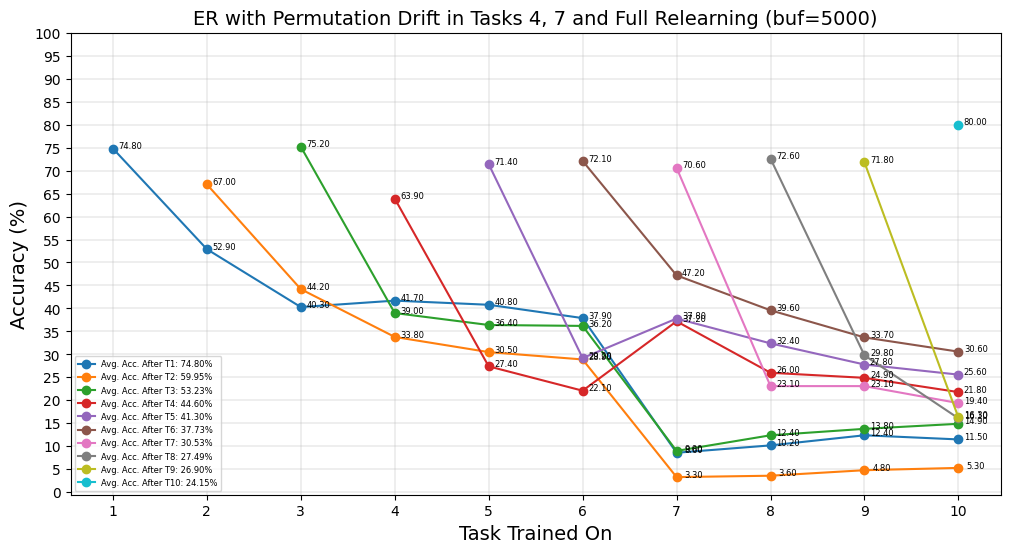

In [21]:
er_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {er_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-23-25-20-18-17-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
# 23.70, 24.15, 24.26
plot_results(
    er_5000_accuracy_array_with_drift_full_relearning,
    title="ER with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_5000_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [22]:
# before reimplementation
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-14-25-01-32-25-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-2-cpd-0.json"
# )
# # 25.62, 25.80, 26.05, 26.42, 26.45
# # 26.068 ± 0.32944802321458827

3 files found
1: ./reimplementation-logs/02-23-25-20-49-20-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-23-25-21-21-12-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-23-25-21-53-57-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 25.706666666666667
Avg Forgetting: 53.58888888888889


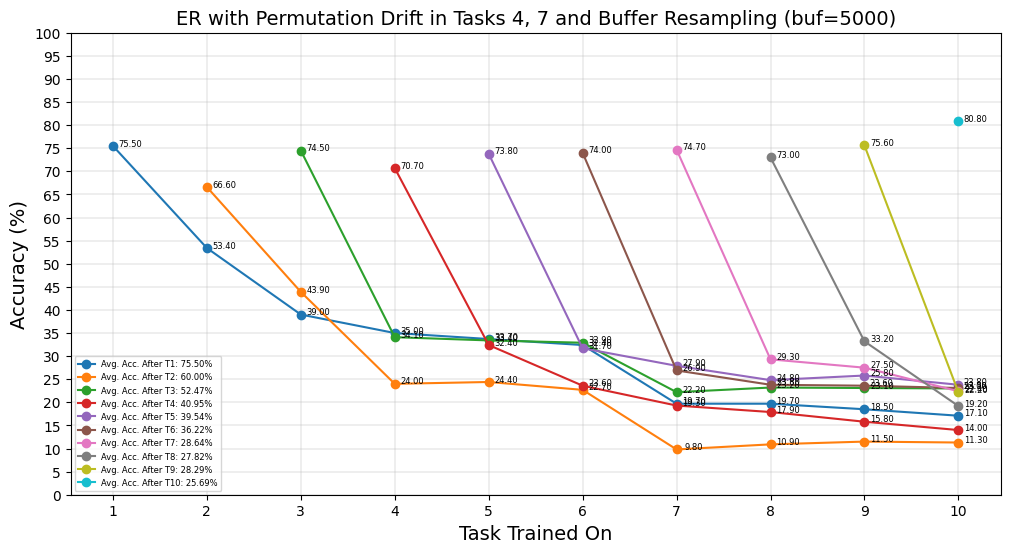

In [23]:
er_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {er_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-23-25-20-49-20-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
# 25.31, 25.69, 26.12
plot_results(
    er_5000_accuracy_array_with_drift_buffer_resampling,
    title="ER with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

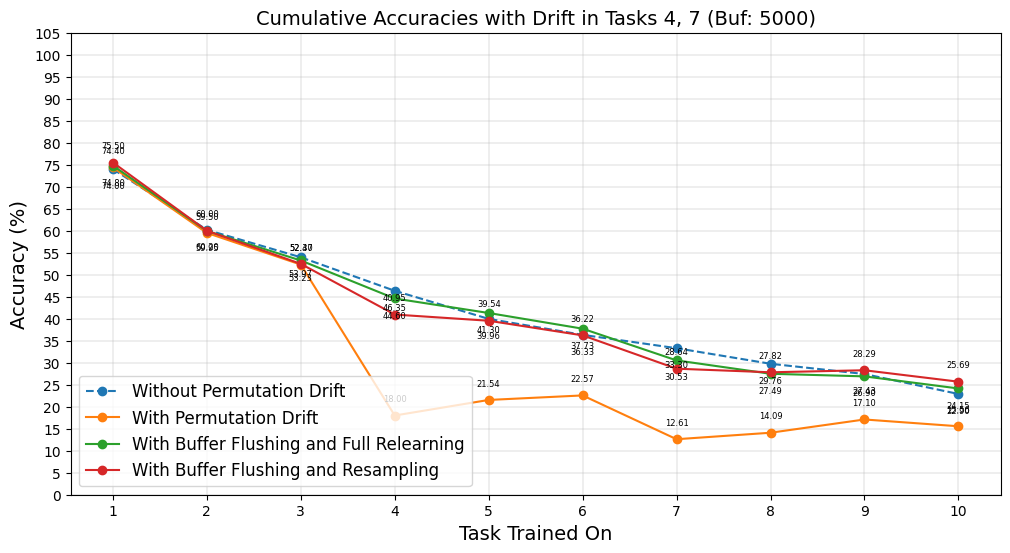

In [24]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Without Drift

In [25]:
er_ace_500_accuracy_array_without_drift = read_results(
    "./logs/01-20-25-05-56-24-seq-cifar100-er_ace-buf-500-drift-6-n-2-adaptation-0.json"
)
# 21.55, 21.91, 22.40
# 21.953333333333333 ± 0.3483612429010365
# plot_results(
#     er_ace_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_ace_500_accuracy_array_without_drift)[1]

39.4

### With Permutation Drift in Tasks 4, 7

In [26]:
er_ace_500_accuracy_array_with_drift = read_results(
    "./logs/01-20-25-22-10-09-seq-cifar100-er_ace-buf-500-drift-5-n-2-adaptation-0.json"
)
# 12.14, 12.28, 12.70
# 12.373333333333335 ± 0.23795424396766288
# plot_results(
#     er_ace_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 4, 7",
# )
average_forgetting(er_ace_500_accuracy_array_with_drift)[1]

48.922222222222224

### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [27]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-20-25-23-42-01-seq-cifar100-er_ace-buf-500-drift-5-n-2-adaptation-1.json"
# )
# # 18.10, 19.02, 19.02
# # 18.713333333333335 ± 0.4336921591277483

3 files found
1: ./reimplementation-logs/02-23-25-21-23-57-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-20-18-35-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-19-08-57-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 18.063333333333333
Avg Forgetting: 42.633333333333326


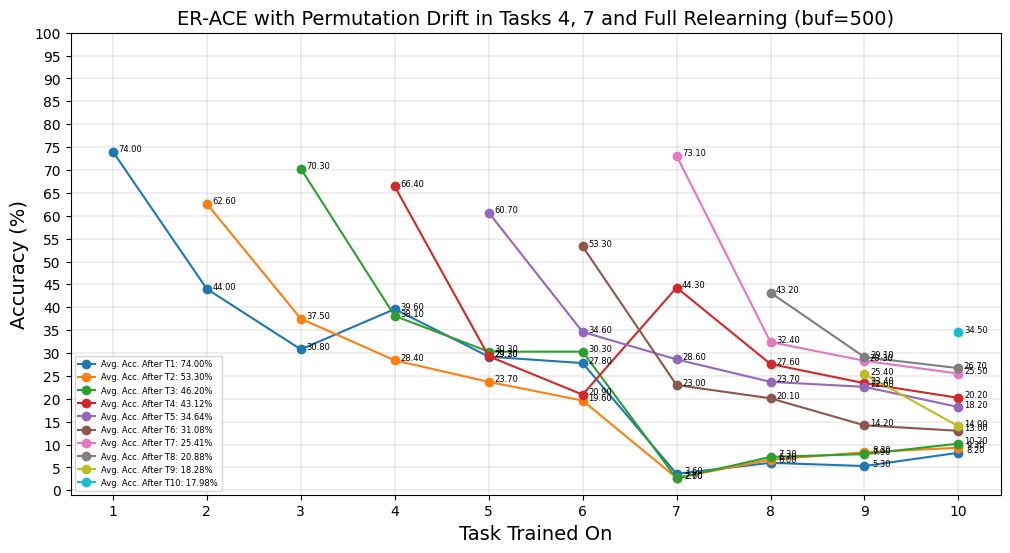

In [28]:
er_ace_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {er_ace_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-23-25-19-08-57-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
# 17.72, 17.98, 18.49
plot_results(
    er_ace_500_accuracy_array_with_drift_full_relearning,
    title="ER-ACE with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_500_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [29]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-03-28-29-seq-cifar100-er_ace-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 16.77, 17.28, 17.37
# # 17.14 ± 0.26419689627245885

3 files found
1: ./reimplementation-logs/02-23-25-23-12-23-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-23-25-22-17-06-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-24-25-00-05-52-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 16.29
Avg Forgetting: 45.577777777777776


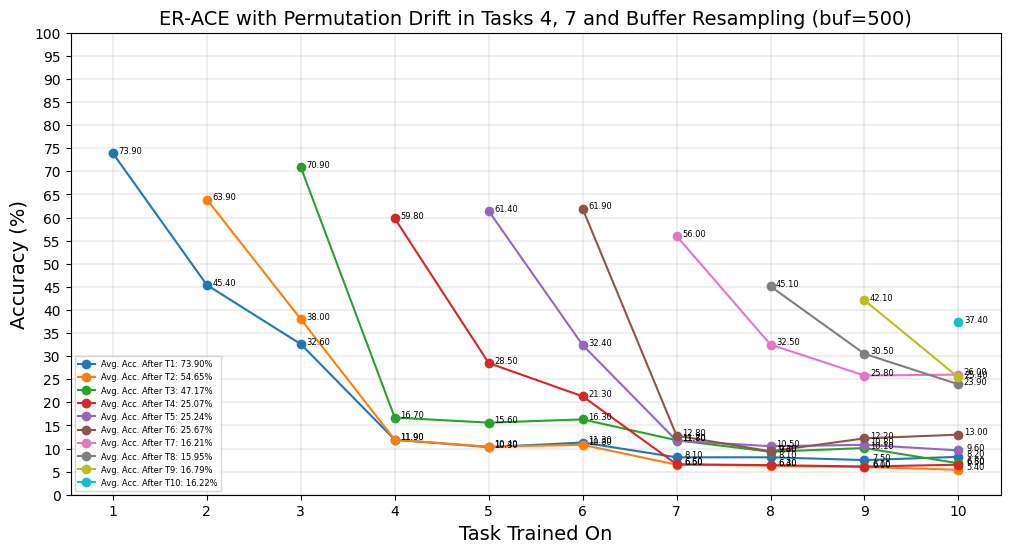

In [30]:
er_ace_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {er_ace_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-23-25-22-17-06-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
# 16.12, 16.22, 16.53
plot_results(
    er_ace_500_accuracy_array_with_drift_buffer_resampling,
    title="ER-ACE with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

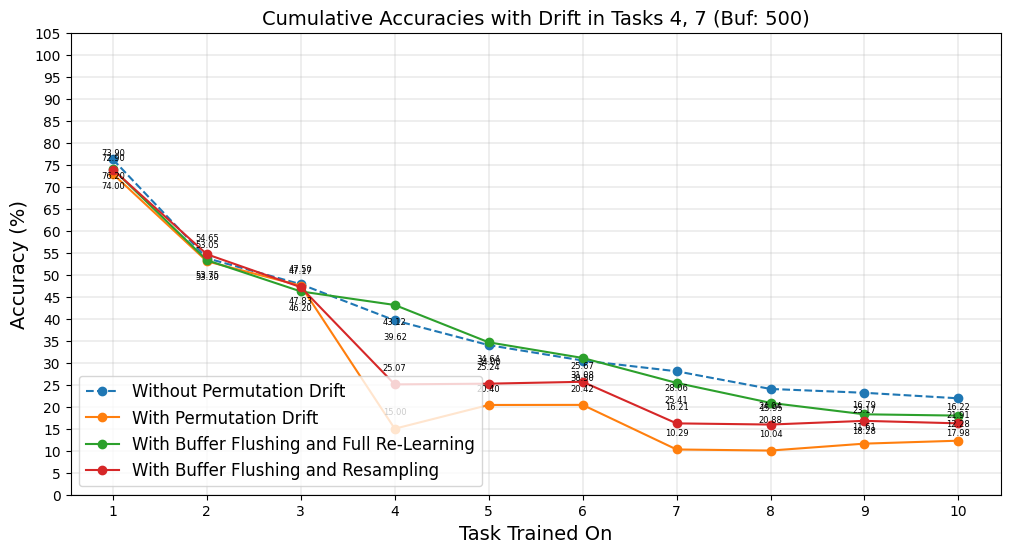

In [31]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [32]:
er_ace_5000_accuracy_array_without_drift = read_results(
    "./logs/01-20-25-08-18-05-seq-cifar100-er_ace-buf-5000-drift-6-n-2-adaptation-0.json"
)
# 31.81, 32.67, 32.85
# 32.443333333333335 ± 0.45382326466980155
# plot_results(
#     er_ace_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_ace_5000_accuracy_array_without_drift)[1]

31.83333333333333

### With Permutation Drift in Tasks 4, 7

In [33]:
er_ace_5000_accuracy_array_with_drift = read_results(
    "./logs/01-21-25-04-44-37-seq-cifar100-er_ace-buf-5000-drift-5-n-2-adaptation-0.json"
)
# 16.43, 16.84, 16.85, 16.94, 16.96
# 16.804000000000002 ± 0.19293522228976281
# plot_results(
#     er_ace_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 4, 7",
# )
average_forgetting(er_ace_5000_accuracy_array_with_drift)[1]

48.5

### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [34]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-21-25-15-37-04-seq-cifar100-er_ace-buf-5000-drift-5-n-2-adaptation-1.json"
# )
# # 28.77, 29.25, 29.52
# # 29.179999999999996 ± 0.3101612483854165

3 files found
1: ./reimplementation-logs/02-23-25-19-16-36-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-21-46-24-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-20-31-07-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 27.363333333333333
Avg Forgetting: 38.599999999999994


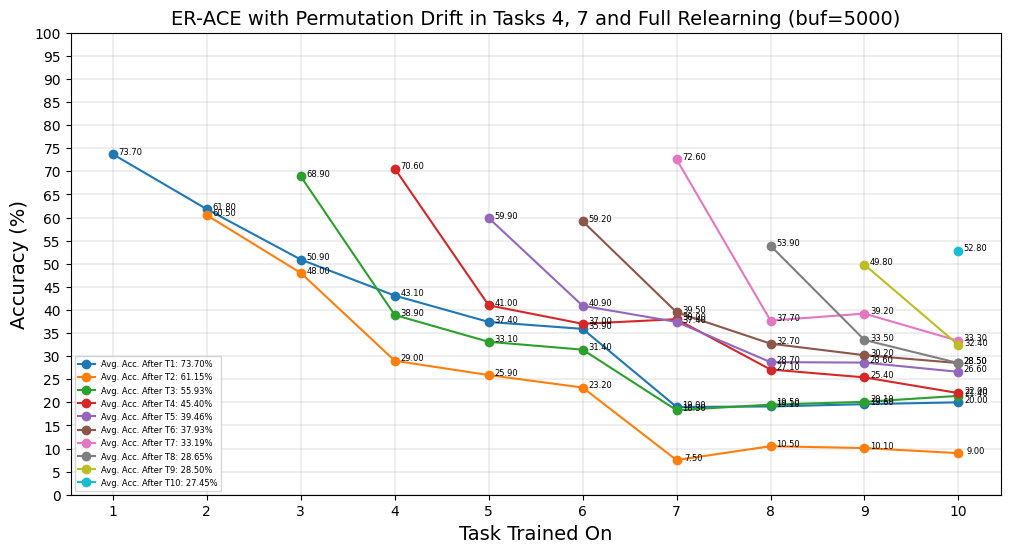

In [35]:
er_ace_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {er_ace_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-23-25-20-31-07-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
# 27.13, 27.45, 27.51
plot_results(
    er_ace_5000_accuracy_array_with_drift_full_relearning,
    title="ER-ACE with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_5000_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [36]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-18-20-46-seq-cifar100-er_ace-buf-5000-drift-5-n-2-adaptation-2.json"
# )
# # 27.39, 27.69, 28.15
# # 27.74333333333333 ± 0.3125522178594936

3 files found
1: ./reimplementation-logs/02-24-25-00-34-03-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-23-25-23-37-49-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-23-25-22-41-31-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 27.290000000000003
Avg Forgetting: 38.86666666666665


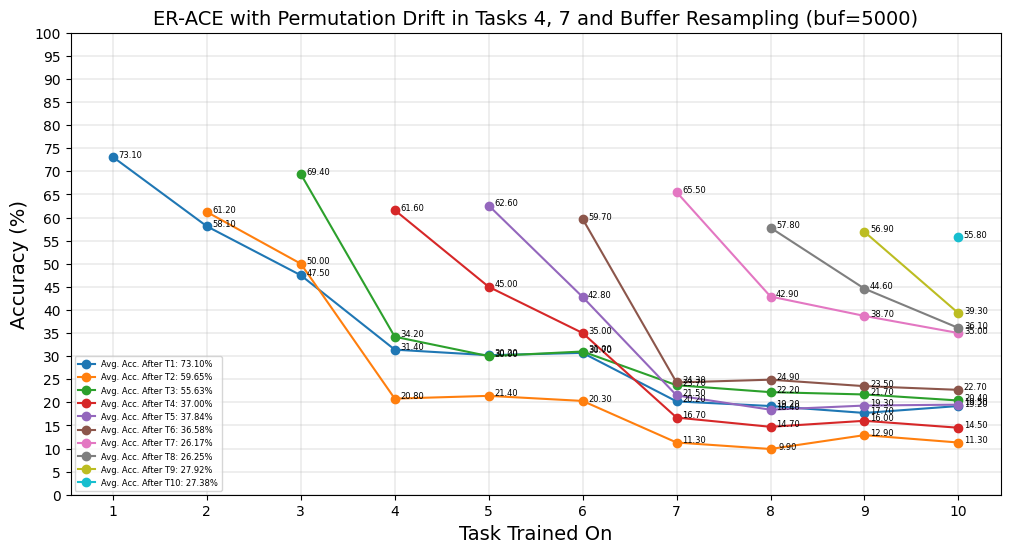

In [37]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {er_ace_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-00-34-03-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
# 27.11, 27.38, 27.38
plot_results(
    er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    title="ER-ACE with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

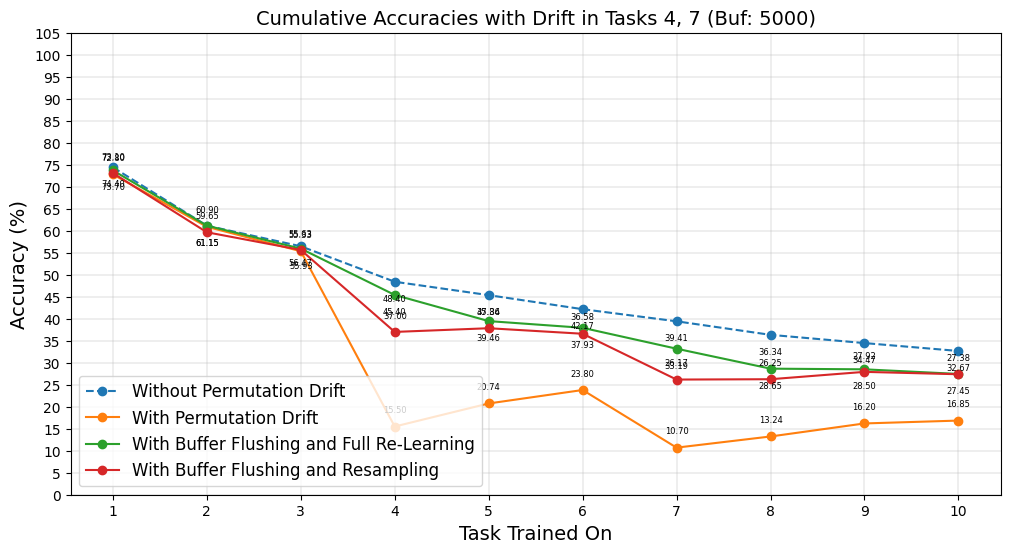

In [38]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Without Drift

In [39]:
derpp_500_accuracy_array_without_drift = read_results(
    "./logs/01-20-25-22-06-38-seq-cifar100-derpp-buf-500-drift-6-n-1-adaptation-0.json"
)
# 12.03, 12.11, 12.20
# 12.113333333333335 ± 0.0694422221866655
# plot_results(
#     derpp_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(derpp_500_accuracy_array_without_drift)[1]

69.80000000000001

### With Permutation Drift in Tasks 4, 7

In [40]:
derpp_500_accuracy_array_with_drift = read_results(
    "./logs/01-21-25-05-01-17-seq-cifar100-derpp-buf-500-drift-5-n-2-adaptation-0.json"
)
# 10.27, 10.36, 10.52
# 10.383333333333333 ± 0.10338708279513883
# plot_results(
#     derpp_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 4, 7",
# )
average_forgetting(derpp_500_accuracy_array_with_drift)[1]

72.03333333333335

### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [ ]:
# before reimplementation
#  derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-21-25-15-35-33-seq-cifar100-derpp-buf-500-drift-5-n-2-adaptation-1.json"
# )
# # 17.13, 17.49, 17.83
# # 17.48333333333333 ± 0.2858126814696799

63.5

3 files found
1: ./reimplementation-logs/02-23-25-23-33-51-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-21-42-22-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-19-51-18-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 16.779999999999998
Avg Forgetting: 63.62222222222223


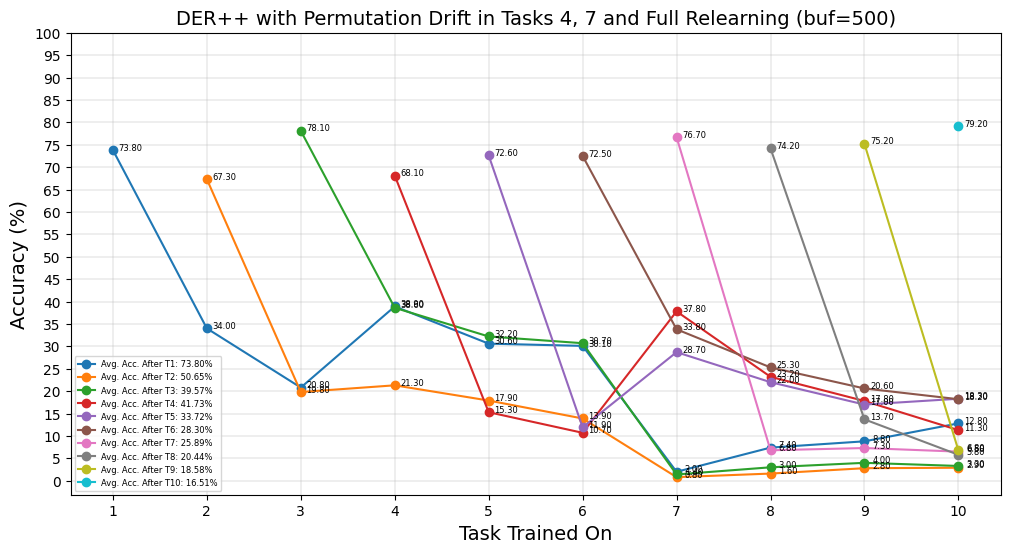

In [41]:
derpp_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {derpp_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

derpp_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-23-25-19-51-18-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
# 16.31, 16.51, 17.52
plot_results(
    derpp_500_accuracy_array_with_drift_full_relearning,
    title="DER++ with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_500_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [42]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-20-07-54-seq-cifar100-derpp-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 13.18, 13.29, 13.40
# # 13.29 ± 0.08981462390205013

3 files found
1: ./reimplementation-logs/02-24-25-03-38-50-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-24-25-02-18-12-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-24-25-00-55-36-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 13.566666666666668
Avg Forgetting: 67.66666666666667


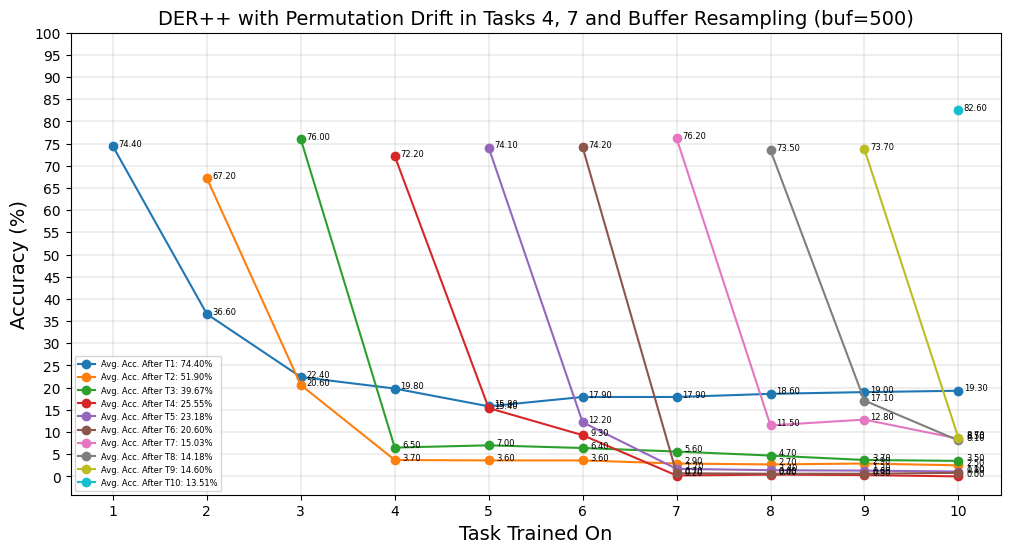

In [48]:
derpp_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {derpp_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-02-18-12-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
# 13.26, 13.51, 13.93
plot_results(
    derpp_500_accuracy_array_with_drift_buffer_resampling,
    title="DER++ with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

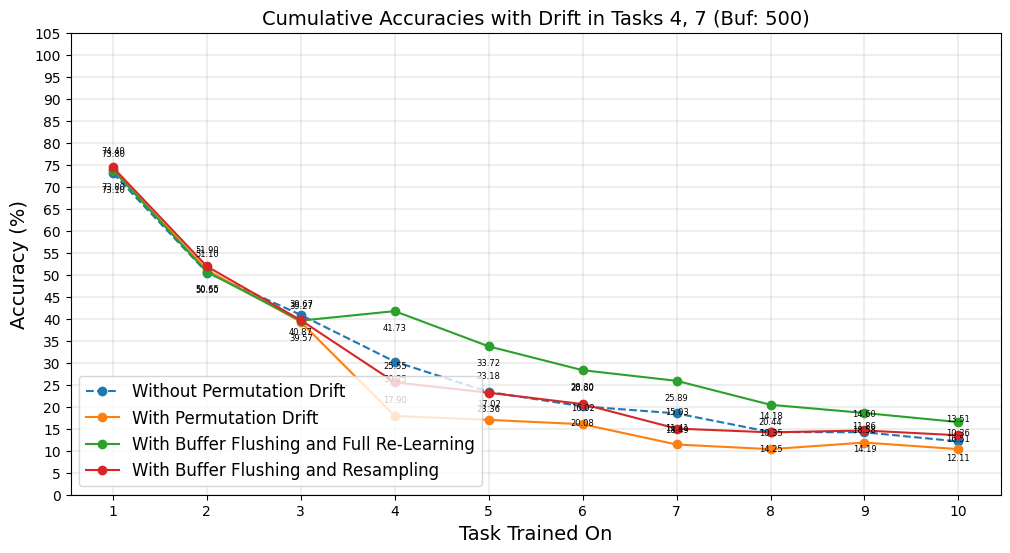

In [49]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

36.13333333333334

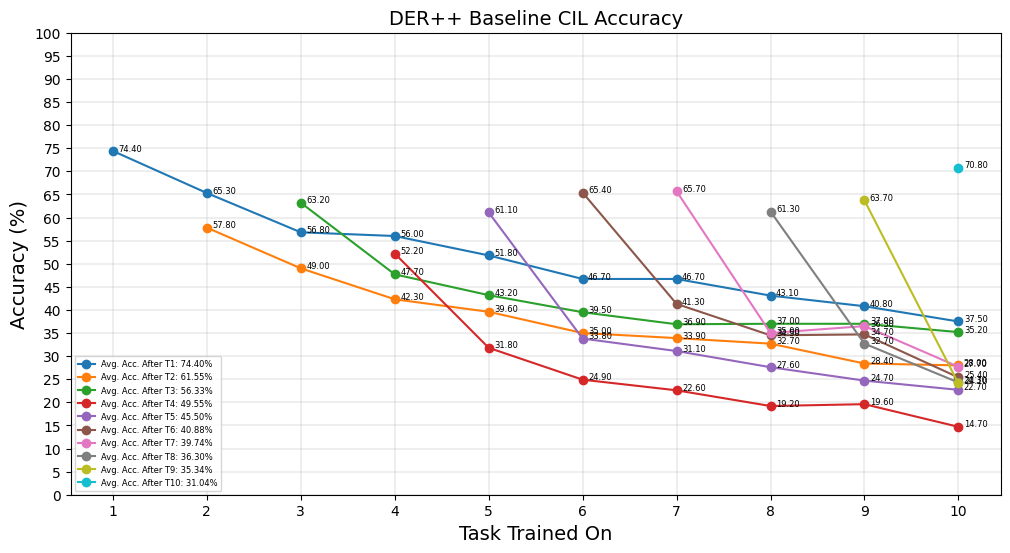

In [50]:
derpp_5000_accuracy_array_without_drift = read_results(
    "./logs/01-21-25-00-05-03-seq-cifar100-derpp-buf-5000-drift-6-n-1-adaptation-0.json"
)
# 30.42, 31.04, 31.17
# 30.876666666666665 ± 0.32724438710066306
plot_results(
    derpp_5000_accuracy_array_without_drift,
    title="DER++ Baseline CIL Accuracy",
)
average_forgetting(derpp_5000_accuracy_array_without_drift)[1]

### With Permutation Drift in Tasks 4, 7

52.47777777777778

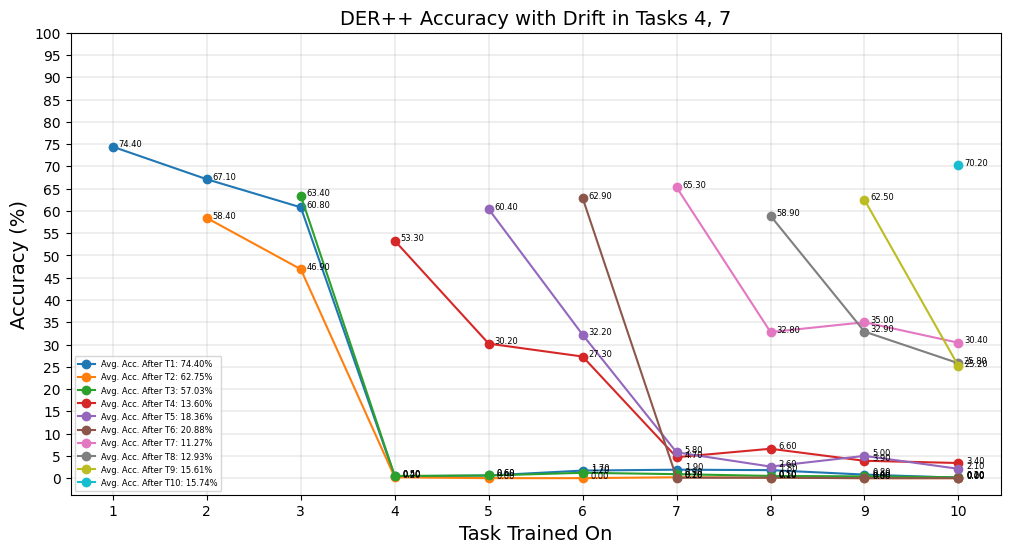

In [51]:
derpp_5000_accuracy_array_with_drift = read_results(
    "./logs/01-21-25-04-00-20-seq-cifar100-derpp-buf-5000-drift-5-n-2-adaptation-0.json"
)
# 15.39, 15.74, 16.31
# 15.813333333333333 ± 0.3791510985814956
plot_results(
    derpp_5000_accuracy_array_with_drift,
    title="DER++ Accuracy with Drift in Tasks 4, 7",
)
average_forgetting(derpp_5000_accuracy_array_with_drift)[1]

### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [52]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-21-25-15-52-35-seq-cifar100-derpp-buf-5000-drift-5-n-2-adaptation-1.json"
# )
# # 30.83, 30.94, 31.19
# # 30.986666666666665 ± 0.15062831370260107

3 files found
1: ./reimplementation-logs/02-23-25-19-58-09-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-21-52-31-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-23-53-33-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 27.340000000000003
Avg Forgetting: 40.17777777777778


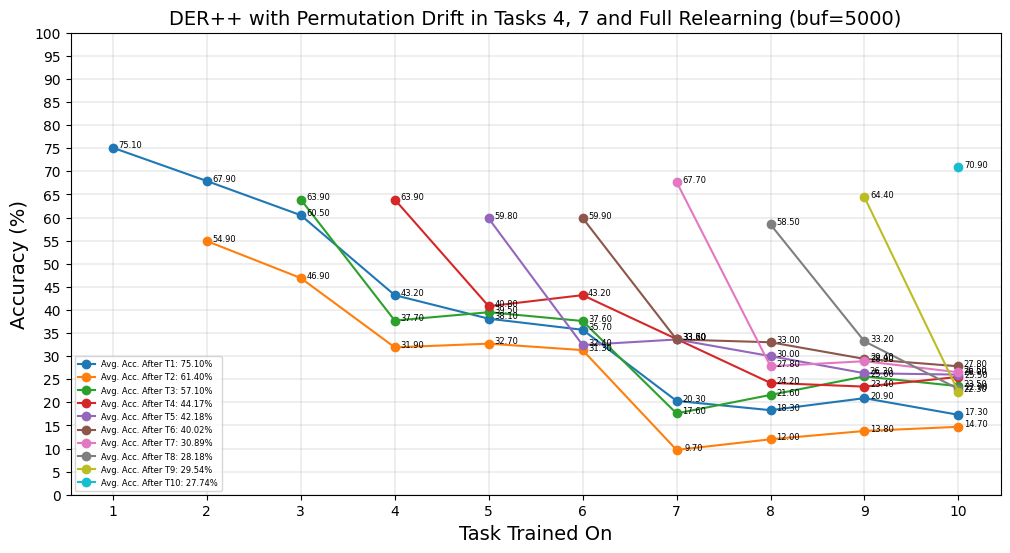

In [57]:
derpp_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {derpp_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-23-25-23-53-33-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
# 26.18, 27.74, 28.10
plot_results(
    derpp_5000_accuracy_array_with_drift_full_relearning,
    title="DER++ with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_5000_accuracy_array_with_drift_full_relearning)[1]}")

### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [58]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-19-29-35-seq-cifar100-derpp-buf-5000-drift-5-n-2-adaptation-2.json"
# )
# # 27.67, 27.74, 28.05
# # 27.819999999999997 ± 0.16512621435334454

3 files found
1: ./reimplementation-logs/02-24-25-02-37-07-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-24-25-03-56-36-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-24-25-01-16-22-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 27.71333333333334
Avg Forgetting: 45.56666666666667


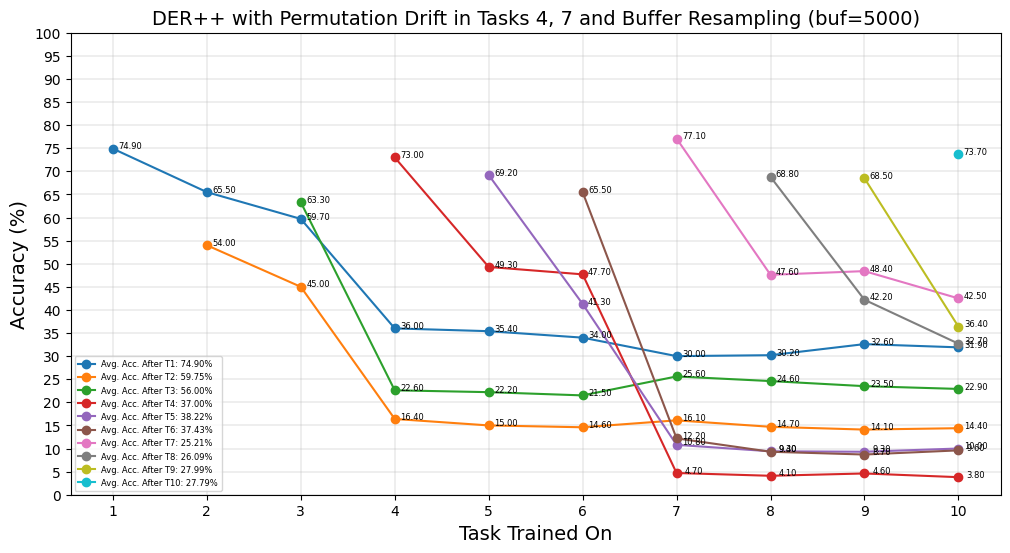

In [64]:
derpp_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {derpp_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-24-25-02-37-07-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
# 27.50, 27.79, 27.85
plot_results(
    derpp_5000_accuracy_array_with_drift_buffer_resampling,
    title="DER++ with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

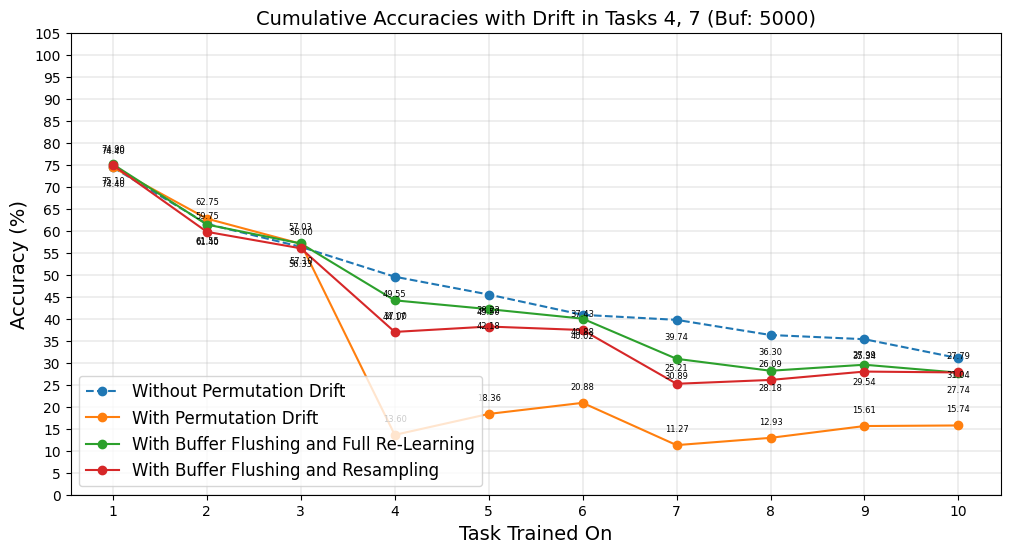

In [65]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

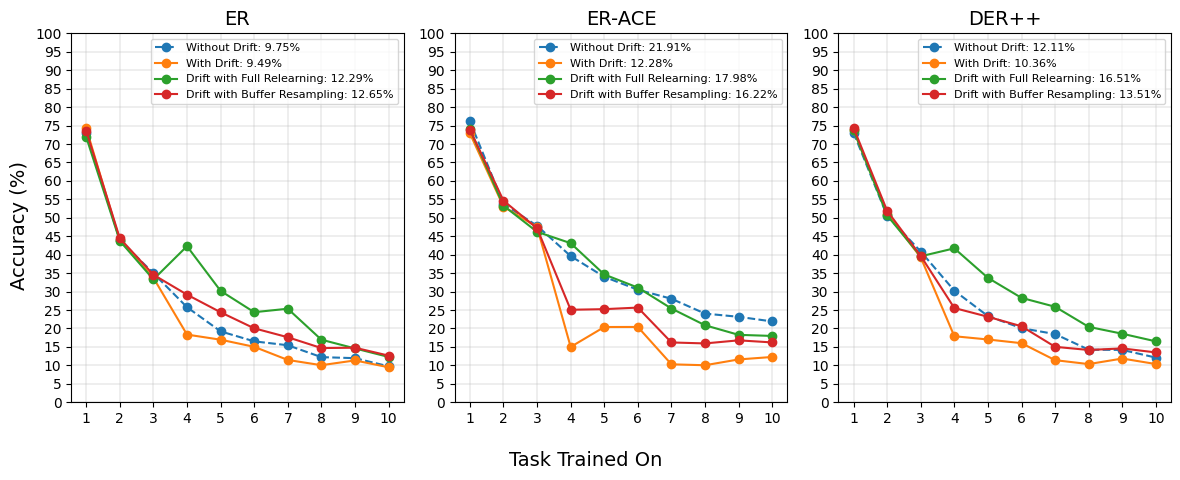

In [72]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR100_Buff_500_n_2.pdf",
)

## Buffer 5000

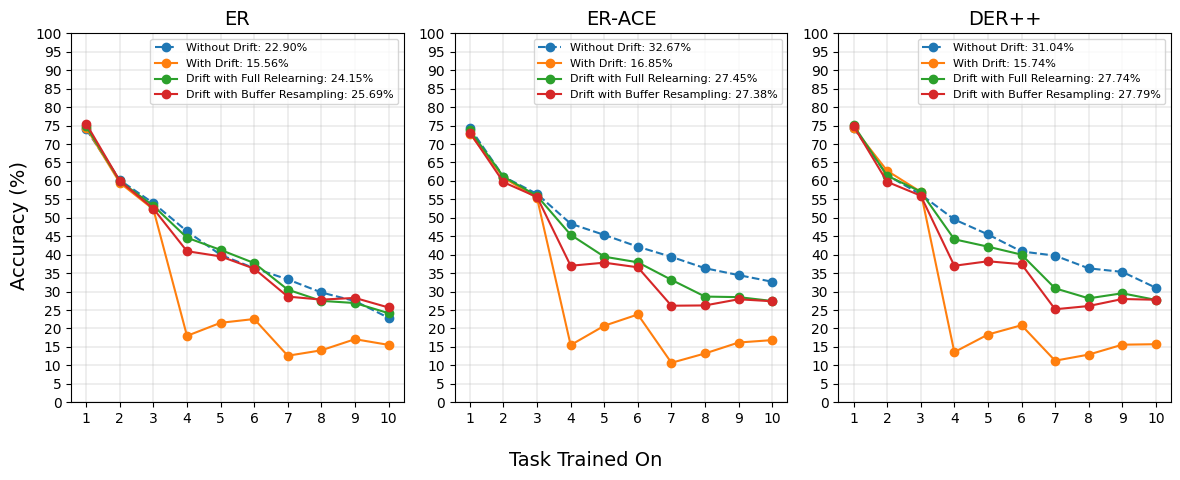

In [73]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR100_Buff_5000_n_2.pdf",
)